Link to competition: https://www.kaggle.com/c/fungi-challenge-fgvc-2018/overview

# Preparations

In [2]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [3]:
from fastai.vision import * 
from fastai.metrics import top_k_accuracy
import json

In [4]:
batch_size = 64

In [5]:
np.random.seed(1991)

# Loading Data

In [6]:
data_path_str = "data"
train_path_str = "train"
test_path_str = "test"

In [8]:
data = ImageDataBunch.from_folder(
    path = data_path_str,
    train = train_path_str,
    test = test_path_str,
    size = 128,
    ds_tfms = get_transforms(),
    bs = batch_size,
    valid_pct = 0.2
).normalize(imagenet_stats)

In [9]:
data

ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
61255_Coprinopsis_stercorea,10235_Amanita_gemmata,19336_Deconica_montana,10266_Amanita_strobiliformis,21143_Tricholoma_scalpturatum
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data

# Visualize Data

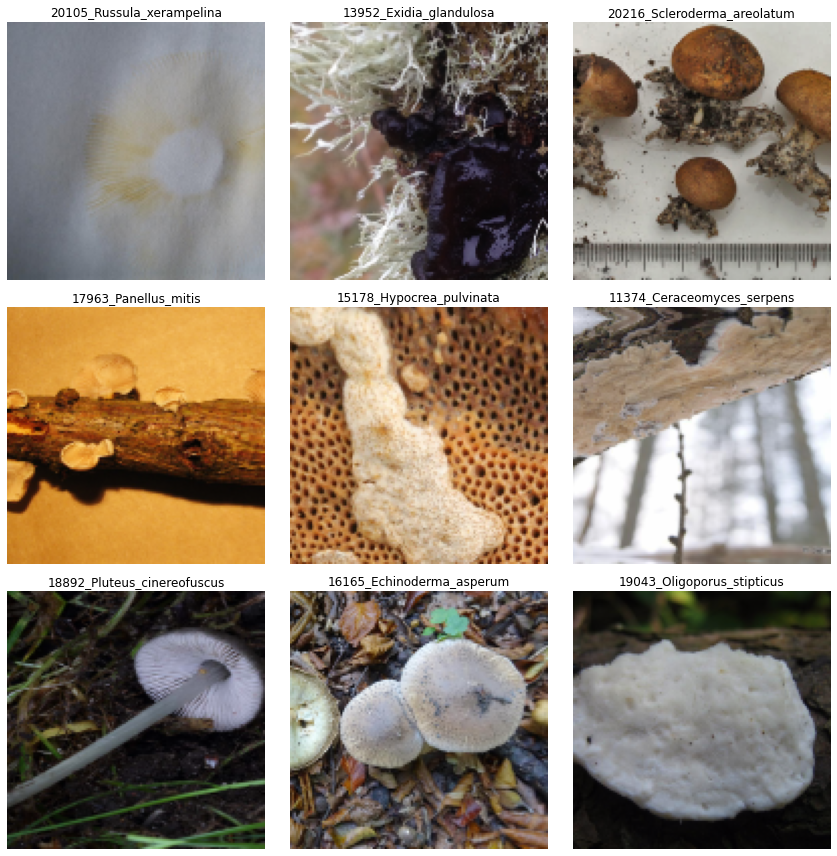

In [10]:
data.show_batch(3)

In [11]:
type(data)

fastai.vision.data.ImageDataBunch

In [12]:
data.c

1394

In [13]:
data.classes

['10000_Abortiporus_biennis',
 '10025_Achroomyces_disciformis',
 '10052_Agaricus_altipes',
 '10056_Agaricus_arvensis',
 '10057_Agaricus_augustus',
 '10059_Agaricus_bernardii',
 '10061_Agaricus_bisporus',
 '10062_Agaricus_bitorquis',
 '10065_Agaricus_campestris',
 '10068_Agaricus_comtulus',
 '10069_Agaricus_cupreobrunneus',
 '10079_Agaricus_impudicus',
 '10082_Agaricus_langei',
 '10083_Agaricus_lanipes',
 '10085_Agaricus_litoralis',
 '10090_Agaricus_moelleri',
 '10097_Agaricus_porphyrizon',
 '10106_Agaricus_dulcidulus',
 '10107_Agaricus_sylvaticus',
 '10108_Agaricus_sylvicola',
 '10111_Agaricus_subfloccosus',
 '10112_Agaricus_subperonatus',
 '10116_Agaricus_xanthodermus',
 '10120_Agrocybe_arvalis',
 '10123_Agrocybe_dura',
 '10127_Agrocybe_pediades',
 '10128_Agrocybe_praecox',
 '10158_Aleuria_aurantia',
 '10174_Aleurodiscus_amorphus',
 '10225_Amanita_ceciliae',
 '10227_Amanita_crocea',
 '10230_Amanita_excelsa',
 '10232_Amanita_franchetii',
 '10234_Amanita_fulva',
 '10235_Amanita_gemmata'

In [14]:
from itertools import groupby

In [15]:
data.y.items

array([1357, 1357, 1357, 1357, ...,  342,  342,  342,  342])

In [16]:
CategoryList(data.y.items, data.y.classes)

CategoryList (71808 items)
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: .

In [17]:
data.y.classes[data.y.items[0]]

'67347_Gliophorus_irrigatus'

In [18]:
labels = [data.y.classes[value] for value in data.y.items]

In [19]:
label_freq = {key: len(list(group)) for key, group in groupby(labels)}

In [20]:
min(label_freq, key=label_freq.get)

'61259_Coprinopsis_laanii'

In [21]:
max(label_freq, key=label_freq.get)

'18882_Plicatura_crispa'

In [22]:
label_freq

{'67347_Gliophorus_irrigatus': 61,
 '13598_Entoloma_exile': 26,
 '60665_Diatrype_decorticata': 33,
 '14610_Helvella_elastica': 50,
 '64651_Hymenoscyphus_fraxineus': 15,
 '18475_Phleogena_faginea': 21,
 '17963_Panellus_mitis': 53,
 '19964_Russula_emetica': 34,
 '45206_Mycena_galopus var. nigra': 26,
 '15468_Inocybe_rimosa': 98,
 '11866_Coltricia_confluens': 18,
 '18925_Pluteus_umbrosus var. umbrosus ': 46,
 '20829_Tapinella_panuoides': 57,
 '63806_Antrodiella_faginea': 4,
 '12479_Cortinarius_largus': 165,
 '12785_Crepidotus_variabilis': 78,
 '18712_Phyllotopsis_nidulans': 19,
 '14069_Fuligo_leviderma': 6,
 '11575_Chamaemyces_fracidus': 6,
 '63641_Hygrocybe_miniata': 132,
 '44721_Mycetinis_querceus': 20,
 '61211_Coprinellus_xanthothrix': 39,
 '11286_Calyptella_gibbosa': 6,
 '20225_Scleroderma_verrucosum': 85,
 '15328_Inocybe_bongardii': 12,
 '18329_Phaeolus_schweinitzii': 137,
 '60939_Sarcomyxa_serotina': 58,
 '17150_Morchella_conica': 9,
 '61650_Tricholoma_frondosae': 21,
 '19919_Russul

<BarContainer object of 1394 artists>

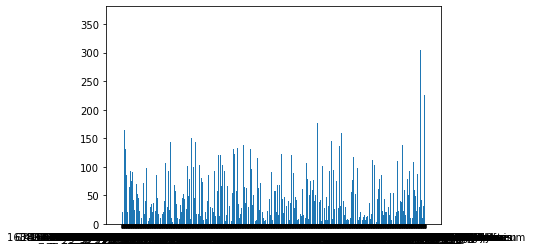

In [23]:
plt.bar(label_freq.keys(), label_freq.values())

# Training the model

In [24]:
top_k_accuracy_3 = partial(top_k_accuracy, k=3)

In [25]:
learner = cnn_learner(data, models.resnet34, metrics=top_k_accuracy_3)

In [ ]:
learner.lr_find()

In [ ]:
learner.recorder.plot()

In [ ]:
lr = 1e-02

In [87]:
fit_one_cycle(learner, 3, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,5.308396,5.010071,0.200089,06:40
1,4.583510,4.138457,0.347872,06:39
2,4.110500,3.720205,0.427195,06:40


In [88]:
learner.save("fungi_resnet34_128_stage1")

## Fine Tuning

In [26]:
learner.load("fungi_resnet34_128_stage1")

FileNotFoundError: [Errno 2] No such file or directory: 'data/models/fungi_resnet34_128_stage1.pth'

In [93]:
learner.unfreeze()

In [94]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


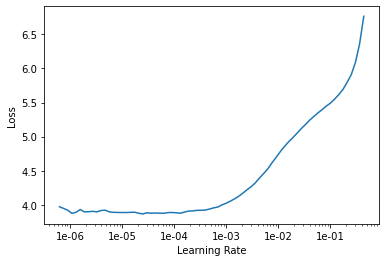

In [95]:
learner.recorder.plot()

In [99]:
lr = slice(1e-6,1e-04)

In [100]:
learner.fit_one_cycle(3, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,3.916291,3.649960,0.439672,06:40
1,3.799667,3.568113,0.450758,06:41
2,3.746780,3.545931,0.454824,06:41


In [101]:
learner.save("fungi_resnet34_128_stage2")

In [104]:
learner.fit_one_cycle(2, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,3.706605,3.507722,0.461063,06:39
1,3.664130,3.476113,0.465909,06:41


In [105]:
learner.save("fungi_resnet34_128_stage3")

## Progressive Resizing

In [103]:
learner.load("fungi_resnet34_128_stage3")

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
16111_Leccinum_scabrum,14062_Fomes_fomentarius,14861_Gliophorus_psittacinus,11903_Coniophora_puteana,18776_Piptoporus_betulinus
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [104]:
data = ImageDataBunch.from_folder(
    path = data_path_str,
    train = train_path_str,
    test = test_path_str,
    size = 256,
    ds_tfms = get_transforms(),
    bs = batch_size,
    valid_pct = 0.2
).normalize(imagenet_stats)

In [105]:
learner.data = data

In [17]:
learner.freeze()

In [14]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


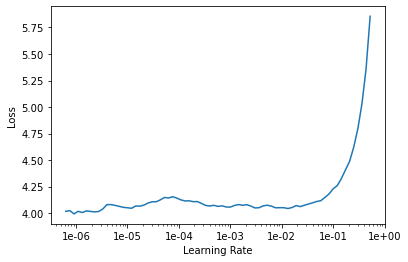

In [15]:
learner.recorder.plot()

In [16]:
lr = 1e-02

In [18]:
fit_one_cycle(learner, 3, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,4.227657,3.801559,0.404969,16:07
1,3.744261,3.150674,0.523284,11:11
2,3.147688,2.765649,0.592190,11:09


In [19]:
learner.save("fungi_resnet34_256_stage1")

### Fine Tuning

In [106]:
learner.load("fungi_resnet34_256_stage1")

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
61255_Coprinopsis_stercorea,10235_Amanita_gemmata,19336_Deconica_montana,10266_Amanita_strobiliformis,21143_Tricholoma_scalpturatum
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [21]:
learner.unfreeze()

In [22]:
learner.lr_find()

epoch,train_loss,valid_loss,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


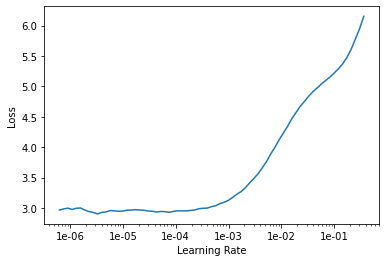

In [23]:
learner.recorder.plot()

In [24]:
lr = slice(1e-6,1e-04)

In [25]:
learner.fit_one_cycle(5, max_lr=lr)

epoch,train_loss,valid_loss,top_k_accuracy,time
0,2.966246,2.731215,0.598095,11:26
1,2.915502,2.656915,0.611798,11:23
2,2.857046,2.599371,0.620488,11:14
3,2.825556,2.571108,0.623552,11:34
4,2.776285,2.568284,0.624721,11:26


In [26]:
learner.save("fungi_resnet34_256_stage2")

# Analyzing results

In [ ]:
learner.load("fungi_resnet34_256_stage2")

In [28]:
results = ClassificationInterpretation.from_learner(learner)

In [29]:
results.most_confused()

[('14824_Hygrocybe_chlorophana', '14823_Hygrocybe_ceracea', 19),
 ('14815_Hygrocybe_acutoconica', '14823_Hygrocybe_ceracea', 12),
 ('40854_Xerocomus_ferrugineus', '11101_Xerocomus_subtomentosus', 11),
 ('10056_Agaricus_arvensis', '10116_Agaricus_xanthodermus', 10),
 ('12280_Cortinarius_anserinus', '12479_Cortinarius_largus', 10),
 ('65745_Suillellus_luridus', '67628_Sutorius_luridiformis', 10),
 ('10994_Basidioradulum_radula', '67679_Xylodon_paradoxus', 9),
 ('10994_Basidioradulum_radula', '12919_Cylindrobasidium_laeve', 8),
 ('11086_Xerocomellus_pruinatus', '11082_Xerocomellus_chrysenteron', 8),
 ('12770_Crepidotus_cesatii', '18882_Plicatura_crispa', 8),
 ('18398_Fomitiporia_punctata', '18385_Fuscoporia_ferrea', 8),
 ('20978_Trametes_hirsuta', '20977_Trametes_gibbosa', 8),
 ('21143_Tricholoma_scalpturatum', '21103_Tricholoma_argyraceum', 8),
 ('40985_Byssomerulius_corium', '12919_Cylindrobasidium_laeve', 8),
 ('63641_Hygrocybe_miniata', '14852_Hygrocybe_miniata var. miniata', 8),
 ('6

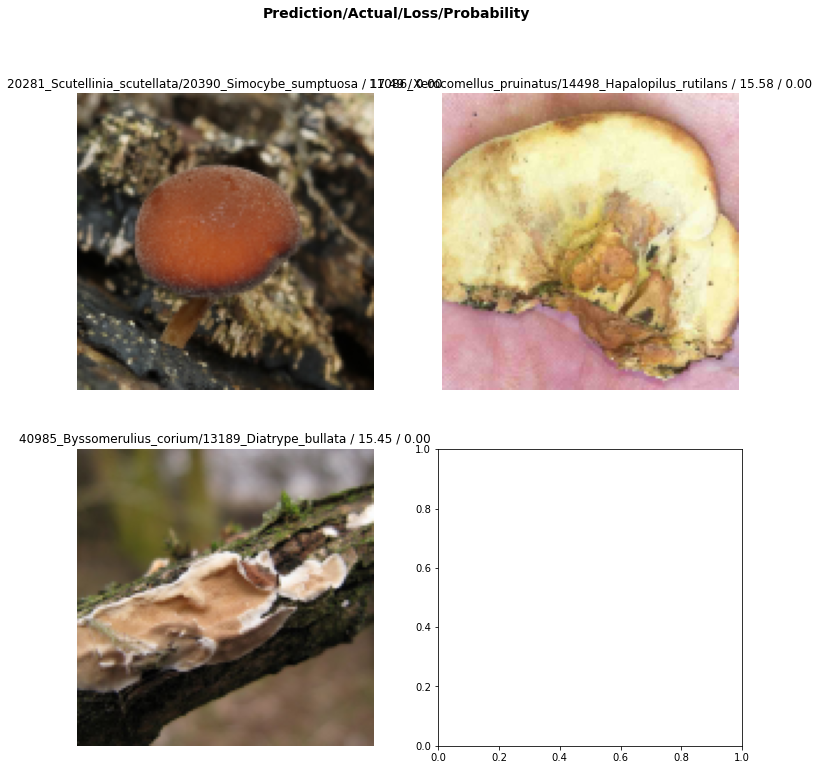

In [30]:
results.plot_top_losses(3)

# Cleaning dataset

In [26]:
from fastai.widgets import * 

In [27]:
?ImageList.databunch

data = ImageDataBunch.from_folder(
    path = data_path_str,
    train = train_path_str,
    test = test_path_str,
    size = 256,
    ds_tfms = get_transforms(),
    bs = batch_size,
    valid_pct = 0.2
).normalize(imagenet_stats)



In [28]:
train_path_str = "data"

In [29]:
data_cln = (ImageList.from_folder(train_path_str)
        .split_none()
        .label_from_folder()
        .transform(get_transforms(), size=256)
        .databunch()
        .normalize(imagenet_stats)
       )

In [33]:
data = ImageDataBunch.from_folder(
    path = data_path_str,
    train = train_path_str,
    test = test_path_str,
    size = 256,
    ds_tfms = get_transforms(),
    bs = batch_size,
    valid_pct = 0.2
).normalize(imagenet_stats)

In [35]:
learner = cnn_learner(data, models.resnet34, metrics=top_k_accuracy_3)


In [36]:
learner.load("fungi_resnet34_256_stage2")

Learner(data=ImageDataBunch;

Train: LabelList (71808 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus,67347_Gliophorus_irrigatus
Path: data;

Valid: LabelList (17952 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
61255_Coprinopsis_stercorea,10235_Amanita_gemmata,19336_Deconica_montana,10266_Amanita_strobiliformis,21143_Tricholoma_scalpturatum
Path: data;

Test: LabelList (9758 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [37]:
ds_top_loss, idxs_top_loss = DatasetFormatter().from_toplosses(learner)


In [44]:
most_unsure = DatasetFormatter.from_most_unsure(learner)
wgt = PredictionsCorrector(*most_unsure)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [ ]:
# path = Path('data/bears')

In [ ]:
ImageCleaner(ds_similar, idxs_similar, data_path_str)

# Prediction

In [27]:
preds, _ = learner.get_preds(ds_type=DatasetType.Test)

In [28]:
pred_classes = [np.array(p).argsort()[-3:][::-1] for p in preds]

In [29]:
pred_classes = [" ".join(p.astype(str) ) for p in pred_classes]

In [30]:
with open("data/test2.json") as json_file:
    data = json.load(json_file)
    files_to_ids = {i["file_name"] : i["id"] for i in data["images"]}

In [31]:
ids = [files_to_ids["test/" + f.name] for f in learner.data.test_ds.items]

In [32]:
pred_classes[:5]

['872 745 20', '628 749 1182', '749 20 1334', '749 390 1289', '564 982 267']

In [33]:
ids[:5]

[123772, 42782, 8956, 52044, 114626]

In [34]:
df = pd.DataFrame({"id": ids, "predicted": pred_classes})

In [35]:
df[:5]

,id,predicted
0,123772,872 745 20
1,42782,628 749 1182
2,8956,749 20 1334
3,52044,749 390 1289
4,114626,564 982 267


In [36]:
df.to_csv('data/submission2.csv', index=False)

# Scores

1. Initial prediction
    - train_loss: 3.401437
    - valid_loss: 3.261729
    - top_k_accuracy: 0.513369
    - test_score private: 0.69770
    - test_score public: 0.70037
2. FInetuning and progressive resizing
    - train_loss: 2.776285
    - valid_loss: 2.568284
    - top_k_accuracy: 0.624721
    - test_score private: 
    - test_score public: 